#### Week3 : Ensemble models and hyperparameter tuning
### Experiment Summary: 
Week1: Logistic regression with L1,L2 and ElasticNet regulariisation <br>
Kaggle result: 0.70770 (for L2) 

Week2 Exp1: Data cleaning - removing negative values <br>
Much less AUC than week1 - therefore, negative valued will be used in further model experiments.
Kaggle result: 0.70677

Week2 Exp2: Balancing datasets (using SMOTE), analysing which class performs better using confusion matrix
AUC - 0.7349 
Kaggle result: 0.708

Week3: Ensemble models and hyperparameter tuning




### 1. Import packages and data

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from hpsklearn import HyperoptEstimator
from hyperopt import Trials, STATUS_OK,tpe, hp, fmin

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [63]:
#loading training dataset 
df_train_original = pd.read_csv('../data/raw/train.csv')
df_test_original = pd.read_csv('../data/raw/test.csv')

### 2. Data analysis 
Summary: <br>
1) There are negative values for Games played (GP), 3 Point attempts (3PMade), 3 Point attempts, 3P%, FT%, BLK (Blocks) <br>
2) The dataset for the dependant variable is imnbalanced. The plot shows that the dataset is not balanced. There are more 1's for Target_5yrs than 0. 


In [64]:
#exploration 
df_train_original.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576663,7.267087,2.807037,6.231213,44.608900,0.264525,0.816563,...,1.947787,71.365825,1.077838,2.168500,3.245300,1.624513,0.648688,0.245212,1.257762,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [65]:
#df_train_original.hist(figsize=(15,30),layout=(9,3))

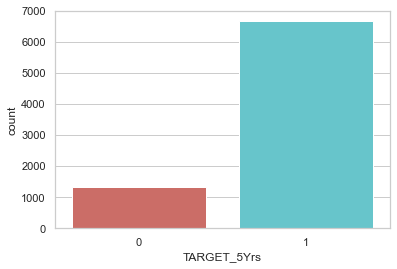

In [66]:
sns.countplot(x='TARGET_5Yrs',data=df_train_original, palette='hls')
plt.show()

In [67]:
df_train_original.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576663,7.267087,2.807037,6.231213,44.608900,0.264525,0.816563,...,1.947787,71.365825,1.077838,2.168500,3.245300,1.624513,0.648688,0.245212,1.257762,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


### 3.Scaling data

In [68]:
# Save target variable
target = df_train_original.pop('TARGET_5Yrs')

In [69]:
#dropping off Ids
df_train_original.drop(['Id','Id_old'], axis=1, inplace=True)

#dropping off correlated fields : for example FG% (Field goals percent), 3P% (3 Point Attempts), FT% (Free Throw Percent),REB(Rebounds)
#df_train_original.drop(['FG%','3P%','FT%'], axis=1, inplace=True)

In [70]:
#feature scaling
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train_original)

from joblib import dump
#Save the scaler into the folder models and call the file scaler.joblib
dump(scaler, '../models/scaler.joblib')



['../models/scaler.joblib']

### 4.Train/Test split

In [71]:
#Splitting the training data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)

x_train, x_val, y_train, y_val = train_test_split(df_train, target, test_size=0.2, random_state=8)

#save models 
np.save('../data/processed/X_train', x_train)
np.save('../data/processed/X_val',   x_val)
np.save('../data/processed/y_train', y_train)
np.save('../data/processed/y_val',   y_val)


### 5.Baseline Random forest model

In [72]:
#baseline random forest model
rfc_1 = RandomForestClassifier()
rfc_1.fit(x_train, y_train)
display(rfc_1.score(x_train, y_train))

#save model as rfc_1
dump(rfc_1,  '../models/rfc_1.joblib')

1.0

['../models/rfc_1.joblib']

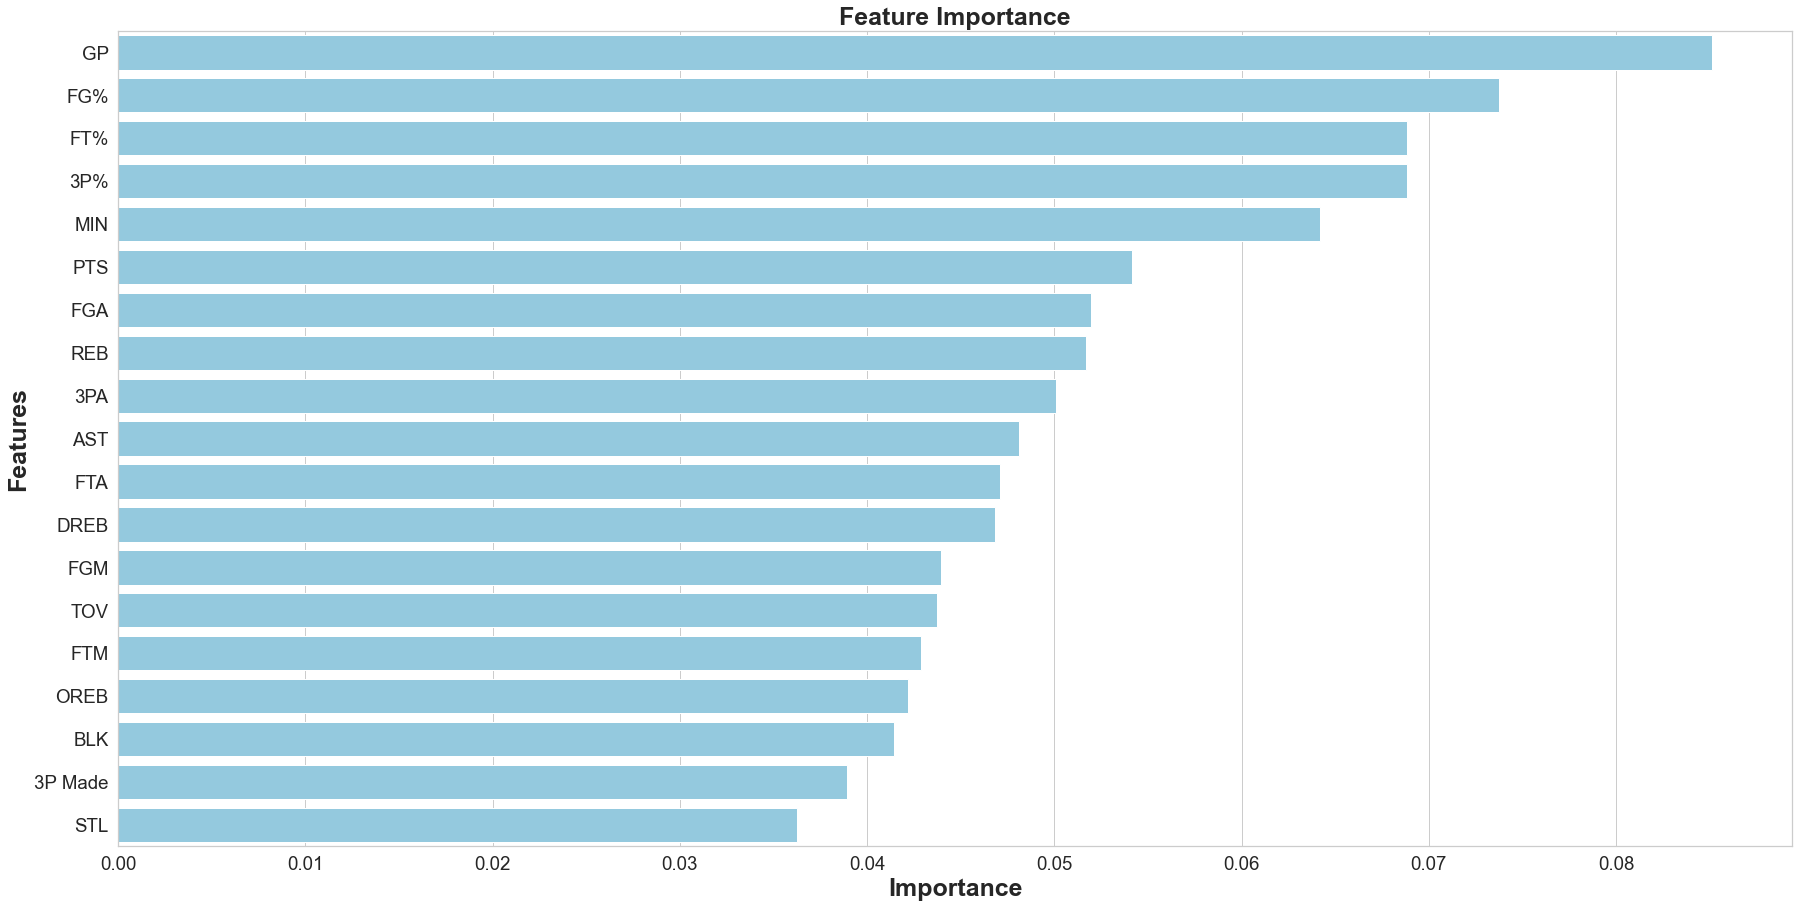

None

,Features,Gini-Importance
0,GP,0.085156
1,FG%,0.073739
2,FT%,0.068859
3,3P%,0.068832
4,MIN,0.064169
5,PTS,0.054162
6,FGA,0.051973
7,REB,0.051697
8,3PA,0.050067
9,AST,0.048088


In [73]:
#feature importance 
feats = {}
for feature, importance in zip(df_train_original.columns, rfc_1.feature_importances_):
    feats[feature] = importance
    
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

The important features (top5) here are Games Played (GP), Field Goals Percent (FT%), Free Throw Percent(FT%), 3-Points Percent (3P%), Minutes Played (MIN), Points Per Game (PTS). 

These feature importances are similar to Logistic regression in week2.

### 6. Principal Component analysis

To improve the baseline model: 
Using dimension reduction, we can approximate the original dataset with fewer variables. Using PCA, we can study the cumulative explained variance ratio of these features to understand which features explain the most variance in the data.

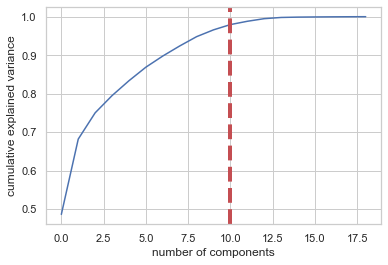

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.485933,0.485933
1,0.681735,0.195802
2,0.750024,0.068288
3,0.794814,0.044790
4,0.833509,0.038695
5,0.868722,0.035213
6,0.897743,0.029021
7,0.923890,0.026147
8,0.948094,0.024203
9,0.965797,0.017704


In [74]:
pca_test = PCA(n_components=19)
pca_test.fit(x_train)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

The graph above shows that after more than 10 components, we don’t gain very much explained variance.

The dataframe shows the Cumulative Variance Ratio (how much total variance of the data is explained) and the Explained Variance Ratio (how much each PCA component explains the total variance of the data).

Looking at the dataframe above, when we use PCA to reduce 19 predicting variables down to 10 components, we can still explain over 95% of the variance. The other 9 components explain less than 5% of the variance, so we can cut them. Using this logic, we will use PCA to reduce the number of components from 19 to 10 for x_train and x_test. 

In [75]:
pca = PCA(n_components=10)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)

In [76]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
    
pca_test_df = pd.DataFrame(pca_test.components_, columns=df_train_original.columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
GP,0.214770,-0.022623,-0.092210,0.093139,-0.049072,-0.719466,0.245864,-0.260332,-0.531249,-0.012732
MIN,0.311448,0.044596,0.039313,-0.073430,0.011575,-0.041326,0.119829,0.004863,0.149921,0.091281
PTS,0.315094,0.040483,-0.008932,0.098344,0.052301,0.090697,-0.164163,0.020922,-0.043522,0.266593
FGM,0.310044,0.013201,-0.005233,0.067299,0.073984,0.040869,-0.159987,0.045025,0.004650,0.423348
FGA,0.303703,0.091625,-0.020046,0.007328,0.019557,0.121400,-0.043691,0.039466,-0.069457,0.466951
FG%,0.105033,-0.325032,0.060860,0.256325,0.255599,-0.430960,-0.610230,-0.021900,0.361043,-0.080692
3P Made,0.100244,0.390280,0.434547,-0.029773,0.157662,0.004920,-0.115576,-0.311776,0.006373,-0.135270
3PA,0.104360,0.403617,0.399016,-0.061911,0.124174,0.053541,-0.068271,-0.320758,0.000982,-0.113274
3P%,0.034499,0.368347,0.245715,0.112797,-0.001181,-0.215147,-0.062412,0.831150,-0.175947,-0.106386
FTM,0.288126,-0.022594,-0.167516,0.209411,-0.046261,0.277820,-0.159050,-0.020613,-0.235812,-0.378437


### 7. Fit to baseline Random forest model after PCA

In [77]:
rfc_2 = RandomForestClassifier()
rfc_2.fit(x_train_pca, y_train)
display(rfc_2.score(x_train_pca, y_train))

#save model as rfc_2
dump(rfc_2,  '../models/rfc_2.joblib')

1.0

['../models/rfc_2.joblib']

### 8. Hyperparameter Tuning Round 1: RandomSearchCV (PCA+tuning)

Starting with RandomSearchCV to consider a wide range of values.

We will be tuning these hyperparameters: <br>
n_estimators: the number of “trees” in our Random Forest.<br>
max_features: the number of features at each split.<br>
max_depth: the max number of “splits”each tree can have.<br>
min_samples_split: the minimum number of observations required before a node of a tree can split itself.<br>
min_samples_leaf: the minimum number of observations required at each leaf at the ends of each tree.<br>
bootstrap: whether to use bootstrapping or not to provide data to each tree in the Random Forest. (Bootstrapping is a random sampling from the dataset with replacement.)

In [78]:

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc_rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rfc_rs.fit(x_train_pca, y_train)
rfc_rs.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1000,
 'min_samples_split': 44,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': True}

In [80]:
rs_df = pd.DataFrame(rfc_rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,1000,44,2,sqrt,9,True,0.834375,1
1,700,23,12,sqrt,8,True,0.834219,2
2,700,18,7,sqrt,7,False,0.834219,2
3,800,28,12,sqrt,14,True,0.834219,4
4,500,12,18,sqrt,13,False,0.834219,5
5,1000,44,23,log2,12,False,0.834063,6
6,700,7,23,log2,12,False,0.834062,7
7,400,2,23,sqrt,11,False,0.834062,7
8,900,50,12,log2,9,True,0.833906,9
9,1000,12,7,sqrt,10,True,0.833906,10


### 8. Hyperparameter Tuning Round 2: HyperOpt


In [48]:

space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    
}

def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, x_train, y_train ,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))


100%|██████████| 100/100 [05:54<00:00,  3.54s/trial, best loss: -0.8353124999999999]
Best: {'criterion': 0, 'max_depth': 13.0, 'n_estimators': 0}


In [58]:

space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "bootstrap": hp.choice("bootstrap", ["True", "False"]),
    "max_features": hp.choice("max_features", ["sqrt", "log2"])
    
}

def objective(space1):
    rfc_hp = RandomForestClassifier(**space1,n_jobs=-1)
    acc = cross_val_score(rfc_hp, x_train_pca, y_train ,scoring="accuracy").mean()
    return{'loss': 1-acc, 'status': STATUS_OK }

best = fmin(
   fn=objective,  
   space=space,      
   algo=tpe.suggest,      
   max_evals=5
)

print("Best: {}".format(best))

100%|██████████| 5/5 [00:25<00:00,  5.19s/trial, best loss: 0.16703124999999996]
Best: {'bootstrap': 0, 'criterion': 1, 'max_depth': 12.0, 'max_features': 0, 'n_estimators': 4}


In [82]:
space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
   # "bootstrap": hp.choice("bootstrap", ["True", "False"]),
    "max_features": hp.choice("max_features", ["sqrt", "log2"])
    
}

def objective(space1):
    rfc_hp = RandomForestClassifier(**space1,n_jobs=-1)
    acc = cross_val_score(rfc_hp, x_train_pca, y_train ,scoring="accuracy").mean()
    return{'loss': -acc, 'status': STATUS_OK }

best = fmin(
   fn=objective,  
   space=space,      
   algo=tpe.suggest,      
   max_evals=5
)

print("Best: {}".format(best))

100%|██████████| 5/5 [00:15<00:00,  3.15s/trial, best loss: -0.83421875]        
Best: {'criterion': 1, 'max_depth': 6.0, 'max_features': 0, 'n_estimators': 0}


### 9. Evaluate Performance Of Models On Val data

In [98]:
#baseline Random forest
y_val_rfc_1 = rfc_1.predict(x_val)
y_val_rfc_1_prob = rfc_1.predict_proba(x_val)[:, 1]
from sklearn.metrics import roc_auc_score
roc_value_1 = roc_auc_score(y_val, y_val_rfc_1_prob)
print(roc_value_1)



#PCA on baseline Random Forest
y_val_pca = rfc_2.predict(x_val_pca)
y_val_rfc_pca_prob = rfc_2.predict_proba(x_val_pca)[:, 1]

roc_value_pca = roc_auc_score(y_val, y_val_rfc_pca_prob)
print(roc_value_pca)


# PCA + Randomsearch hyper parameter optimisation 
y_val_pca_rs = rfc_rs.predict(x_val_pca)
y_val_pca_rs_prob = rfc_rs.predict_proba(x_val_pca)[:, 1]

roc_value_pca_rs = roc_auc_score(y_val, y_val_pca_rs_prob)
print(roc_value_pca_rs)

# PCA + HyperOpt hyper parameter optimisation
#y_pred_pca_hp = rfc_hp.predict(x_val_pca)
y_val_pca_hp = rfc_hp.predict(x_val_pca)
y_val_pca_hp_prob = rfc_hp.predict_proba(x_val_pca)[:, 1]

roc_value_pca_rs = roc_auc_score(y_val, y_val_pca_hp_prob)
print(y_val_pca_hp_prob)

1.0
0.9686979584284217
0.9822775961676844


NameError: name 'rfc_hp' is not defined

### 5. Applying Prediction to test data

In [100]:
#using baseline Random forest model 
#standardising test data 

df_test = df_test_original.drop(['Id','Id_old'], axis=1)
df_test = scaler.fit_transform(df_test)
y_test_rfc_1 = rfc_1.predict_proba(df_test)

final_pred =pd.DataFrame(y_test_rfc_1[:,1], index=df_test_original['Id'])
final_pred.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
final_pred.to_csv('../data/processed/Week3RFC_1.csv' )

In [101]:
#using PCA Random forest model 
#standardising test data 

df_test = df_test_original.drop(['Id','Id_old'], axis=1)
df_test = scaler.fit_transform(df_test)
df_test_pca = pca.transform(df_test)


y_test_rfc_pca = rfc_2.predict_proba(df_test_pca)

final_pred =pd.DataFrame(y_test_rfc_pca[:,1], index=df_test_original['Id'])
final_pred.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
final_pred.to_csv('../data/processed/Week3RFC_pca.csv' )